In [1]:
!pip install h5py

In [68]:
import h5py
import os
import pandas as pd
import numpy as np
import uuid

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import btrdb
from btrdb.utils.timez import *

In [2]:
path_to_data = os.path.join('../../../../../Volumes/NO NAME/sentinel')

In [3]:
os.listdir(path_to_data)

['._bedford_2013-03-01_00.h5',
 '._bedford_2013-03-01_01.h5',
 '._bedford_2013-03-01_02.h5',
 '._bedford_2013-03-01_03.h5',
 'bedford_2013-03-01_00.h5',
 '._bedford_2013-03-01_04.h5',
 '._bedford_2013-03-01_05.h5',
 'bedford_2013-03-01_02.h5',
 'bedford_2013-03-01_01.h5',
 '._bedford_2013-03-01_06.h5',
 '._bedford_2013-03-01_07.h5',
 'bedford_2013-03-01_06.h5',
 '._bedford_2013-03-01_08.h5',
 'bedford_2013-03-01_07.h5',
 '._bedford_2013-03-01_10.h5',
 '._bedford_2013-03-01_11.h5',
 '._bedford_2013-03-01_12.h5',
 '._bedford_2013-03-01_13.h5',
 'bedford_2013-03-01_05.h5',
 'bedford_2013-03-01_04.h5',
 'bedford_2013-03-01_03.h5',
 'bedford_2013-03-01_12.h5',
 '._Laurel_Thesis.pdf',
 'bedford_2013-03-01_13.h5',
 'bedford_2013-03-01_11.h5',
 'bedford_2013-03-01_10.h5',
 'bedford_2013-03-01_08.h5',
 'Laurel_Thesis.pdf']

In [4]:
f = h5py.File(os.path.join(path_to_data, 'bedford_2013-03-01_00.h5'), 'r')

In [5]:
f.keys()

<KeysViewHDF5 ['alldata', 'general']>

In [6]:
f['general'].keys()

<KeysViewHDF5 ['cdatetime', 'comment', 'date', 'detlabel', 'dettype', 'detver', 'location', 'utchour', 'version']>

In [7]:
f['alldata'].keys()

<KeysViewHDF5 ['ac_voltage', 'freq', 'latitude', 'longitude', 'neutral_current', 'neutral_to_ground', 'rms_record', 'sat_num', 'sync_status']>

## Notes to self:
- Figure out how to find missing data


In [27]:
keys = []
for key in f['alldata'].keys():
    if 'raw' in f['alldata'][key]:
        keys.append(key)

In [28]:
keys

['ac_voltage',
 'freq',
 'latitude',
 'longitude',
 'neutral_current',
 'neutral_to_ground',
 'rms_record',
 'sat_num',
 'sync_status']

In [56]:
laurels_api_key = '2301C47D67FB1C2C48D0CC7B'
db = btrdb.connect("api.ni4ai.org:4411", apikey=laurels_api_key)

collection = 'lndunn/sentinel/bedford'
annotations = {'latitude': np.average(f['alldata']['latitude']['raw']),
              'longitude': np.average(f['alldata']['longitude']['raw'])}

tags = {'ac_voltage': {'name': 'voltage', 'unit': 'volts'},
        'freq': {'name': 'frequency', 'unit': 'Hz'},
        'neutral_current': {'name': 'neutral_current', 'unit': 'amps'},
        'sync_status': {'name': 'sync_stats', 'unit': 'mask'}
        }

uuids = dict(zip(tags.keys(), [uuid.uuid4() for key in tags.keys()]))

In [58]:
for s in db.streams_in_collection(collection):
    s.obliterate()

In [59]:
for key in tags.keys():
    s = db.create(uuid=uuids[key],
                  collection=collection,
                  tags=tags[key],
                  annotations=None)

In [61]:
db.streams(uuids['freq'])

<StreamSet(1 stream)>

In [ ]:
tstamps = []
meas = []

for s in tags.keys():
    name = tags[s]['name']
    stream = db.streams(uuids[s])[0]
    for hr in range(24):
        print(hr)
        f = h5py.File(os.path.join(path_to_data, 'bedford_2013-03-01_%s.h5'%(str(hr).zfill(2))), 'r')
        if not f['alldata'][s]['nogaps']:
            print('has gaps!', hr)
        else:
            dt     = f['alldata'][s]['dt'][0]
            start  = f['alldata'][s]['tstart'][0]
            n_obs  = len(f['alldata'][s]['raw'])

            scale  = f['alldata'][s]['scale'][0]
            offset = f['alldata'][s]['offset'][0]

            time = 1e9*(dt*np.arange(0, n_obs) + start)
            meas = scale * pd.Series(f['alldata'][s]['raw']) + offset
            
            tnow = datetime.now()
            stream.insert(list(zip(time.tolist(), meas.tolist())))
            print(str(datetime.now()-tnow).split('.')[0])

0


In [72]:
hasattr(stream[0], 'insert')

True

In [54]:
print(len(tstamps), ns_to_datetime(tstamps[0]), ns_to_datetime(tstamps[-1]))

180000000 2013-03-01 00:00:00+00:00 2013-03-01 00:59:59.999980+00:00


In [45]:
'bedford_2013-03-01_%s.h5'%(str(hr).zfill(2))

TypeError: 'str' object is not callable

In [23]:
# print(dir(f['alldata']['latitude']))
print(f['alldata']['neutral_current'].keys())
print(f['alldata']['neutral_current']['raw'][0])

print(f['alldata']['neutral_current']['scale'][0])
print(f['alldata']['neutral_current']['offset'][0])

print('tstart', f['alldata']['neutral_current']['tstart'][0])
print('sstart', f['alldata']['neutral_current']['sstart'][0])
print(f['alldata']['neutral_current']['dt'][0])
print(f['alldata']['neutral_current']['tlength'])
print(f['alldata']['neutral_current']['yunit'])
# f['alldata']['longitude']

<KeysViewHDF5 ['datumsize', 'datumtype', 'dt', 'fileinfo', 'fs', 'name', 'nogaps', 'offset', 'raw', 'scale', 'slength', 'sstart', 'successfulwrite', 'tlength', 'tstart', 'tunit', 'yunit']>
-893
0.0001525972
0.0
tstart 1362096000.0
sstart 0
2e-05
<HDF5 dataset "tlength": shape (1,), type "<f8">
<HDF5 dataset "yunit": shape (), type "|S1">


In [14]:
f['alldata']['neutral_current']['nogaps'][0]

1

In [26]:
f['alldata']['neutral_current']['scale']*pd.Series(f['alldata']['neutral_current']['raw'][:10])+f['alldata']['neutral_current']['offset']

0   -0.136269
1   -0.133828
2   -0.131386
3   -0.131691
4   -0.128182
5   -0.119178
6   -0.114601
7   -0.122536
8   -0.133980
9   -0.131691
dtype: float32

In [15]:
sum(pd.Series(f['alldata']['neutral_current']['raw'])==0)

56088

In [19]:
8760*2*len(f['alldata']['neutral_current']['raw'])/1e9

3153.6

In [12]:

points = 0
for key in f['alldata'].keys():
    if 'raw' in f['alldata'][key].keys():
        dt     = f['alldata'][key]['dt'][0]
        start  = f['alldata'][key]['tstart'][0]
        n_obs  = len(f['alldata'][key]['raw'])

        scale  = f['alldata'][key]['scale'][0]
        offset = f['alldata'][key]['offset'][0]
        
        tstamps = pd.Series(range(n_obs))
        tstamps *= 1e9*dt
        tstamps += 1e9*start
        print(ns_to_datetime(tstamps.iloc[0]), ns_to_datetime(tstamps.iloc[-1]), len(tstamps))
        
        if s not in db.streams_in_collection(collection):
            s = db.create(uuid=uuid.uuid4(),
                  collection=collection,
                  tags={"name": key, "unit": unit},
    #                       annotations=json.dumps(metadata)
                 )
        
        s.insert(zip(tstamps.tolist(), f['alldata'][key]['raw_data']))
    break

2013-03-01 00:00:00+00:00 2013-03-01 00:59:59.999980+00:00 180000000


In [11]:
start, dt

(1362096000.0, 2e-05)

In [29]:
f['alldata']['ac_voltage'].keys()

<KeysViewHDF5 ['datumsize', 'datumtype', 'dt', 'fileinfo', 'fs', 'name', 'nogaps', 'offset', 'raw', 'scale', 'slength', 'sstart', 'successfulwrite', 'tlength', 'tstart', 'tunit', 'yunit']>

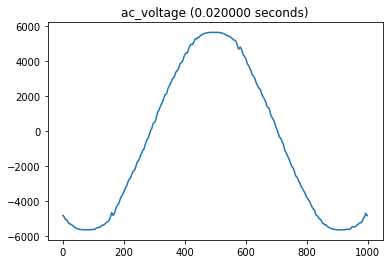

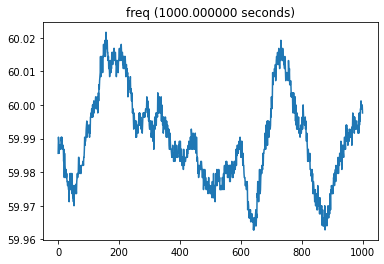

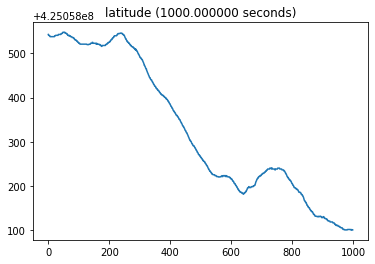

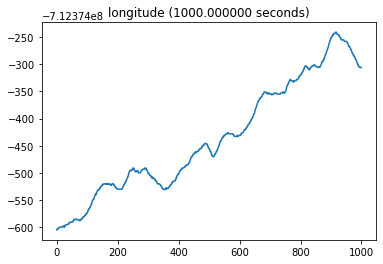

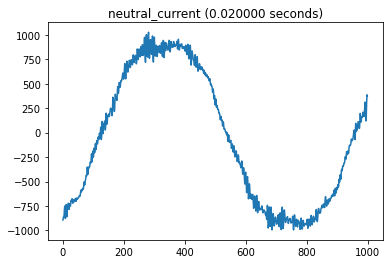

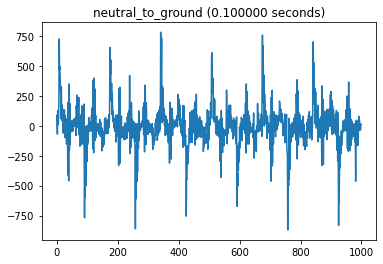

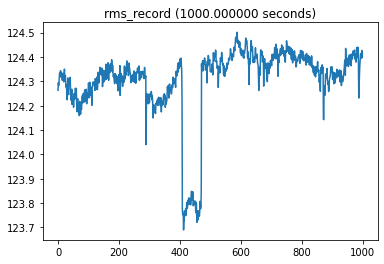

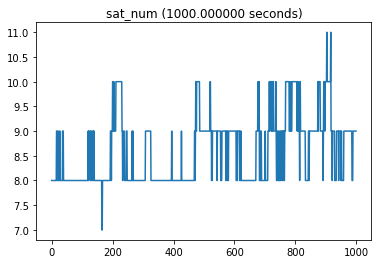

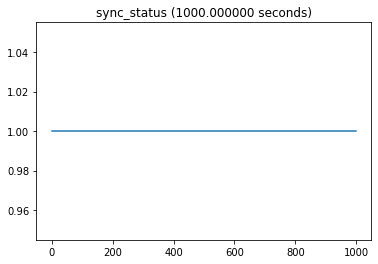

In [51]:
from matplotlib import pyplot as plt

for key in f['alldata'].keys():
    if 'raw' in f['alldata'][key].keys():
        n = 1000*f['alldata'][key]['dt'][0]
        fig, ax = plt.subplots()
        ax.plot(f['alldata'][key]['raw'][:1000])
        ax.set_title(key + ' (%f seconds)'%(n))
        plt.show()

In [41]:
for key in f['alldata']['freq'].keys():
    try:
        print(key, len(f['alldata']['freq'][key]))
    except:
        pass

datumsize 1
dt 1
fileinfo 1
fs 1
nogaps 1
offset 1
raw 3600
scale 1
slength 1
sstart 1
successfulwrite 1
tlength 1
tstart 1


In [40]:
f['alldata'].keys()

<KeysViewHDF5 ['ac_voltage', 'freq', 'latitude', 'longitude', 'neutral_current', 'neutral_to_ground', 'rms_record', 'sat_num', 'sync_status']>

In [42]:
f['general'].keys()

<KeysViewHDF5 ['cdatetime', 'comment', 'date', 'detlabel', 'dettype', 'detver', 'location', 'utchour', 'version']>

In [44]:
for key in f['general'].keys():
        print(key, f['general'][key])

cdatetime <HDF5 dataset "cdatetime": shape (), type "|S23">
comment <HDF5 dataset "comment": shape (), type "|S1">
date <HDF5 dataset "date": shape (), type "|S10">
detlabel <HDF5 dataset "detlabel": shape (), type "|S46">
dettype <HDF5 dataset "dettype": shape (), type "|S3">
detver <HDF5 dataset "detver": shape (), type "|S1">
location <HDF5 dataset "location": shape (), type "|S1">
utchour <HDF5 dataset "utchour": shape (1,), type "<i4">
version <HDF5 dataset "version": shape (), type "|S5">


In [47]:
f['general']['utchour'][0]

0